In [1]:
####################
### Dependencies ###
####################

import requests as rq
from dotenv import load_dotenv
import os
import json
import pandas as pd
from io import StringIO
from IPython.display import display
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup as bs
import sqlite3 as sql
import psycopg as pg
import asyncio
import nest_asyncio
from scipy.stats import norm
import numpy as np
import subprocess

In [2]:
#####################
### General Setup ###
#####################

nest_asyncio.apply()
load_dotenv()

True

In [11]:
#################################
### Import data into Postgres ###
#################################

import_file = "/home/tev/Documents/precincts-with-results.geojson"
command = "/nix/store/v2qqya4p0fy042a260jq1lgbzvim4wpc-gdal-3.9.2/bin/ogr2ogr"
POSTGRES_DB = os.getenv("POSTGRES_DB")
POSTGRES_USER = os.getenv("POSTGRES_USER")
POSTGRES_PASSWORD = os.getenv("POSTGRES_PASSWORD")
POSTGRES_ENDPOINT = os.getenv("POSTGRES_ENDPOINT")
r = subprocess.run([command, "-f", "PostgreSQL", f"PG:host={POSTGRES_ENDPOINT} dbname={POSTGRES_DB} user={POSTGRES_USER} password={POSTGRES_PASSWORD}", import_file, "-nln", POSTGRES_DB, "-nlt", "PROMOTE_TO_MULTI"])
r.returncode

0

In [3]:
##################################
### Setup PostgreSQL Constants ###
##################################

# Make a connection to the database
activateCon = lambda : pg.Connection.connect(os.getenv("DB_URI"), cursor_factory=pg.ClientCursor)
con = activateCon()
cur = con.cursor()

statename = {
    1: ('Alabama', 'AL'),
    2: ('Alaska', 'AK'),
    3: ('American Samoa *', ''),
    4: ('Arizona', 'AZ'),
    5: ('Arkansas', 'AR'),
    6: ('California', 'CA'),
    7: ('Canal Zone', ''),
    8: ('Colorado', 'CO'),
    9: ('Connecticut', 'CT'),
    10: ('Delaware', 'DE'),
    11: ('District of Columbia', 'DC'),
    12: ('Florida', 'FL'),
    13: ('Georgia', 'GA'),
    14: ('Guam', ''),
    15: ('Hawaii', 'HI'),
    16: ('Idaho', 'ID'),
    17: ('Illinois', 'IL'),
    18: ('Indiana', 'IN'),
    19: ('Iowa', 'IA'),
    20: ('Kansas', 'KS'),
    21: ('Kentucky', 'KY'),
    22: ('Louisiana', 'LA'),
    23: ('Maine', 'ME'),
    24: ('Maryland', 'MD'),
    25: ('Massachusetts', 'MA'),
    26: ('Michigan', 'MI'),
    27: ('Minnesota', 'MN'),
    28: ('Mississippi', 'MS'),
    29: ('Missouri', 'MO'),
    30: ('Montana', 'MT'),
    31: ('Nebraska', 'NE'),
    32: ('Nevada', 'NV'),
    33: ('New Hampshire', 'NH'),
    34: ('New Jersey', 'NJ'),
    35: ('New Mexico', 'NM'),
    36: ('New York', 'NY'),
    37: ('North Carolina', 'NC'),
    38: ('North Dakota', 'ND'),
    39: ('Ohio', 'OH'),
    40: ('Oklahoma', 'OK'),
    41: ('Oregon', 'OR'),
    42: ('Pennsylvania', 'PA'),
    43: ('Puerto Rico *', ''),
    44: ('Rhode Island', 'RI'),
    45: ('South Carolina', 'SC'),
    46: ('South Dakota', 'SD'),
    47: ('Tennessee', 'TN'),
    48: ('Texas', 'TX'),
    49: ('Utah', 'UT'),
    50: ('Vermont', 'VT'),
    51: ('Virginia', 'VA'),
    52: ('Virgin Islands of the U.S. *', ''),
    53: ('Washington', 'WA'),
    54: ('West Virginia', 'WV'),
    55: ('Wisconsin', 'WI'),
    56: ('Wyoming', 'WY'),
    60: ('American Samoa', 'AS'),
    64: ('Federated States of Micronesia', 'FM'),
    66: ('Guam', 'GU'),
    67: ('Johnston Atoll', ''),
    68: ('Marshall Islands', 'MH'),
    69: ('Northern Mariana Islands', 'MP'),
    70: ('Palau', 'PW'),
    71: ('Midway Islands', ''),
    72: ('Puerto Rico', 'PR'),
    74: ('U.S. Minor Outlying Islands', 'UM'),
    76: ('Navassa Island', ''),
    78: ('Virgin Islands of the U.S.', 'VI'),
    79: ('Wake Island', ''),
    81: ('Baker Island', ''),
    84: ('Howland Island', ''),
    86: ('Jarvis Island', ''),
    89: ('Kingman Reef', ''),
    95: ('Palmyra Atoll', ''),
}

In [12]:
###########################
### Setup PostgreSQL DB ###
###########################

# Initialize transformed tables AFTER IMPORTING THE GEOJSON FILE
cur.execute('''
    CREATE TABLE transformed AS
    SELECT
        ogc_fid AS id,
        ST_CollectionExtract(ST_MakeValid(ST_GeomFromWKB(wkb_geometry))) AS geo,
        substring(geoid from 1 for 2)::INT AS state,
        substring(geoid from 3 for 3)::INT AS county,
        votes_dem AS dem,
        votes_rep AS rep,
        votes_total AS total
    from jerry;

    INSERT INTO meta (state, type, level)
        SELECT state, 0, 0
        FROM transformed
        GROUP BY state;

    INSERT INTO groups (runid, geo, dem, rep, total)
        SELECT m.runid, t.geo, COALESCE(t.dem, 0), COALESCE(t.rep, 0), COALESCE(t.total, 0)
        FROM transformed AS t
        JOIN meta AS m ON t.state = m.state;
''')
con.commit()
con.close()

In [4]:
##################################
### Test PostgreSQL Connection ###
##################################

con = activateCon()
cur = con.cursor()

cur.execute('''
    SELECT * FROM meta;
''').fetchall()



[(1, 44, 0, None, 0, None),
 (2, 11, 0, None, 0, None),
 (3, 42, 0, None, 0, None),
 (4, 40, 0, None, 0, None),
 (5, 9, 0, None, 0, None),
 (6, 15, 0, None, 0, None),
 (7, 26, 0, None, 0, None),
 (8, 48, 0, None, 0, None),
 (9, 19, 0, None, 0, None),
 (10, 30, 0, None, 0, None),
 (11, 21, 0, None, 0, None),
 (12, 17, 0, None, 0, None),
 (13, 37, 0, None, 0, None),
 (14, 28, 0, None, 0, None),
 (15, 5, 0, None, 0, None),
 (16, 56, 0, None, 0, None),
 (17, 29, 0, None, 0, None),
 (18, 54, 0, None, 0, None),
 (19, 4, 0, None, 0, None),
 (20, 34, 0, None, 0, None),
 (21, 10, 0, None, 0, None),
 (22, 35, 0, None, 0, None),
 (23, 45, 0, None, 0, None),
 (24, 6, 0, None, 0, None),
 (25, 39, 0, None, 0, None),
 (26, 36, 0, None, 0, None),
 (27, 31, 0, None, 0, None),
 (28, 50, 0, None, 0, None),
 (29, 13, 0, None, 0, None),
 (30, 16, 0, None, 0, None),
 (31, 41, 0, None, 0, None),
 (32, 46, 0, None, 0, None),
 (33, 32, 0, None, 0, None),
 (34, 53, 0, None, 0, None),
 (35, 38, 0, None, 0, None)

In [35]:
##############################
### Define Async Functions ###
##############################

loop = asyncio.get_event_loop()

# Define asynchronous function decorator to allow for asynchronous execution within the loop
def asyn(f):
    global loop
    def wrapped(*args, **kwargs):
        global loop
        return loop.run_in_executor(None, f, *args, **kwargs)
    return wrapped

def aawait(f):
    global loop
    return loop.run_until_complete(f)

In [43]:
###################################
### Async Run State Simulations ###
###################################

runs = {
    "ohio": ["{{880, 30}, {88, 30}}", 25], # Ohio 30x30 trial
    "california": ["{{500, 30}, {58, 30}}", 24], # California 30x30 trial
    "wisconsin": ["{{700, 30}, {72, 30}}", 44], # Wisconsin 30x30 trial
    "penns": ["{{700, 30}, {67, 30}}", 3], # Penns 30x30 trial
    "nevada": ["{{200, 30}, {17, 30}}", 33], # Nevada 30x30 trial
    "arizona": ["{{150, 30}, {15, 30}}", 19], # Arizona 30x30 trial
    "illinois": ["{{1000, 30}, {102, 30}}", 12], # Illinois 30x30 trial
    "texas": ["{{1000, 30}, {254, 30}}", 8], # Texas 30x30 trial
    "kansas": ["{{700, 30}, {105, 30}}", 41] # Kansas 30x30 trial
}

@asyn
def do_state(runid):
    global runs
    con = activateCon()
    cur = con.cursor()
    id = cur.execute("select create_layers(%(layers)s::INT[][], %(runid)s);", {'layers': runs[runid][0], 'runid': runs[runid][1]}).fetchall()[0][0]
    con.commit()
    con.close()
    print(id)


tasks = [do_state(state) for state in ["california", "wisconsin", "penns", "nevada", "arizona", "illinois", "texas", "kansas"]]
while True:
    print(f"Working... {[i.done() for i in tasks]}")
    if all([i.done() for i in tasks]):
        break
    aawait(asyncio.sleep(2))

Working... [False, False, False, False, False, False, False, False]
Working... [False, False, False, False, False, False, False, False]
Working... [False, False, False, False, False, False, False, False]
Working... [False, False, False, False, False, False, False, False]
Working... [False, False, False, False, False, False, False, False]
Working... [False, False, False, False, False, False, False, False]
Working... [False, False, False, False, False, False, False, False]
Working... [False, False, False, False, False, False, False, False]
Working... [False, False, False, False, False, False, False, False]
Working... [False, False, False, False, False, False, False, False]
Working... [False, False, False, False, False, False, False, False]
Working... [False, False, False, False, False, False, False, False]
Working... [False, False, False, False, False, False, False, False]
Working... [False, False, False, False, False, False, False, False]
Working... [False, False, False, False, False, F

In [49]:
################################
### Import actual state data ###
################################

con = activateCon()
cur = con.cursor()

stateinfo = pd.DataFrame(cur.execute('''
    select SUM(d) as dem, SUM(r) as rep, count(*) as tot, state
    from (
        select
            (CASE when SUM(dem) > SUM(rep) then 1 else 0 end) as d,
            (CASE when SUM(dem) < SUM(rep) then 1 else 0 end) as r,
            state
        from transformed as t
        group by state, county
    )
    group by state;
''').fetchall())

stateinfo = stateinfo.set_axis(['dem', 'rep', 'tot', 'state'], axis=1)
print(stateinfo)

con.close()

    dem  rep  tot  state
0     1    0    1     11
1     5    0    5     44
2    13   54   67     42
3     0   75   75     40
4     6    2    8      9
5     4    0    4     15
6     8   60   68     26
7    22  232  254     48
8     5   93   98     19
9     7   49   56     30
10    1    9   10     21
11   14   88  102     17
12   25   75  100     37
13   28   54   82     28
14    6   67   73      5
15    2   21   23     56
16    3    1    4     29
17    0   55   55     54
18    5   10   15      4
19   14    7   21     34
20    2    1    3     10
21   14   19   33     35
22   13   33   46     45
23   35   23   58      6
24    7   81   88     39
25   21   41   62     36
26    2   91   93     31
27   13    1   14     50
28   30  129  159     13
29    1   18   19     16
30   10   26   36     41
31    6   50   56     46
32    2   15   17     32
33   13   26   39     53
34    2   51   53     38
35   12   55   67     12
36   10   14   24     24
37   14    0   14     25
38    3   26   29     49


In [111]:
#######################################
### Load simulation and actual data ###
#######################################

con = activateCon()
cur = con.cursor()

ids = {
    1: 39, # Ohio 30x30
    9: 55, # Wisconsin 30x30
    10: 32, # Nevada 30x30
    11: 4, # Arizona 30x30
    12: 55, # Wisconsin 30x30
    13: 42, # Pennsylvania 30x30
    14: 42, # Pennsylvania 30x30
    15: 17, # Illinois 30x30
    16: 20, # Kansas 30x30
    17: 6, # California 30x30
    18: 6, # California 30x30
    19: 48 # Texas 30x30
}

id = 10
state_num = ids[id]
data = pd.DataFrame(cur.execute("select * from results where resid = %(id)s;", {'id': id}).fetchall())
data = data.set_axis(['runid', 'resid', 'dem', 'rep', 'total'], axis=1)
print(data)

con.commit()
con.close()

     runid  resid  dem  rep  total
0     3133     10    4   14     18
1     3139     10    2   16     18
2     3141     10    3   15     18
3     3146     10    3   15     18
4     3148     10    2   16     18
..     ...    ...  ...  ...    ...
895   6912     10    3   15     18
896   6915     10    4   14     18
897   6918     10    2   16     18
898   6924     10    2   16     18
899   6926     10    2   16     18

[900 rows x 5 columns]


Red_mean, Red_std:  15.331111111111111 0.6862132625508307
Blue_mean, Blue_std:  2.667777777777778 0.6864860755142254


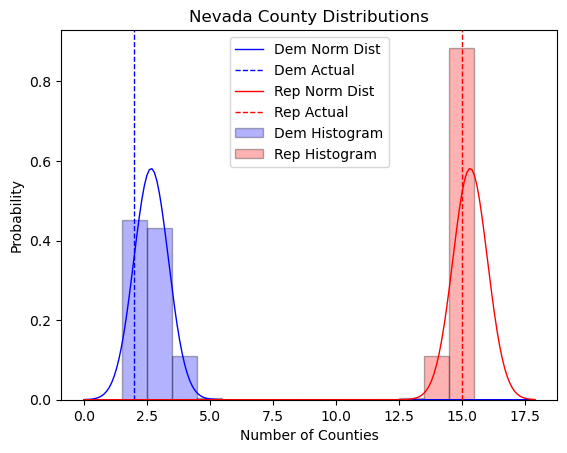

In [112]:
######################
### Visualize data ###
######################

total_county = stateinfo[stateinfo['state']==state_num]['tot'].iloc[0]
rows = len(data)
x_axis = np.arange(0, total_county+1, 0.1)
bin_size = 1

blue_mean = data["dem"].mean()
blue_std = data["dem"].std()
actual_blue= stateinfo[stateinfo['state']==state_num]['dem'].iloc[0]    # placeholder

red_mean = data["rep"].mean()
red_std = data["rep"].std()
actual_red= stateinfo[stateinfo['state']==state_num]['rep'].iloc[0]    # placeholder

print("Red_mean, Red_std: ", red_mean, red_std)
print("Blue_mean, Blue_std: ", blue_mean, blue_std)

#combined plot
plt.hist(data["dem"], bins=range(1,total_county, bin_size), color='b', weights=[1/rows/bin_size]*rows, align="left", alpha=0.3, edgecolor='black')
plt.hist(data["rep"], bins=range(1,total_county, bin_size), color='r', weights=[1/rows/bin_size]*rows, align="left", alpha=0.3, edgecolor='black')
plt.plot(x_axis, norm.pdf(x_axis, loc=data["dem"].mean(), scale=data["dem"].std()), color='b', linewidth=1)
plt.axvline(x=actual_blue, color='b', linestyle='dashed', linewidth=1)
plt.plot(x_axis, norm.pdf(x_axis, loc=data["rep"].mean(), scale=data["rep"].std()), color='r', linewidth=1)
plt.axvline(x=actual_red, color='r', linestyle='dashed', linewidth=1)
plt.title(f"{statename[state_num][0]} County Distributions")
plt.set_xticks(range(1,total_county))
plt.xlabel("Number of Counties")
plt.ylabel("Probability")
plt.legend(["Dem Norm Dist", "Dem Actual", "Rep Norm Dist", "Rep Actual", "Dem Histogram", "Rep Histogram"], loc="upper center")
plt.show()